# Point Labelling Facial Landmark Data
Modify landmark detection function to label certain points on the face. Get the masks of each cluster and use it to "sift" the landmark points

------
# Colour Segmentation using KMeans

In [1]:
!pip install -q mediapipe
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
"""
README: recommended to run this notebook on Google Colab
please download your own local copy to avoid making changes in the repo for this file.
The images are in 'res' of the python project so just change the directories to whatever your image path is.
"""

Mounted at /content/drive


In [3]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [4]:
def resize_images(image1, image2, factor):
  if image1.shape[0] > image2.shape[0]:
    image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
    if image1.shape[0] > 512 or image1.shape[1] > 512:
        image1 = cv2.resize(image1, (int(image1.shape[1]//factor), int(image1.shape[0]//factor)))
        image2 = cv2.resize(image2, (int(image2.shape[1]//factor), int(image2.shape[0]//factor)))
    return image1, image2
  else:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    if image1.shape[0] > 512 or image1.shape[1] > 512:
        image1 = cv2.resize(image1, (int(image1.shape[1]//factor), int(image1.shape[0]//factor)))
        image2 = cv2.resize(image2, (int(image2.shape[1]//factor), int(image2.shape[0]//factor)))
    return image1, image2

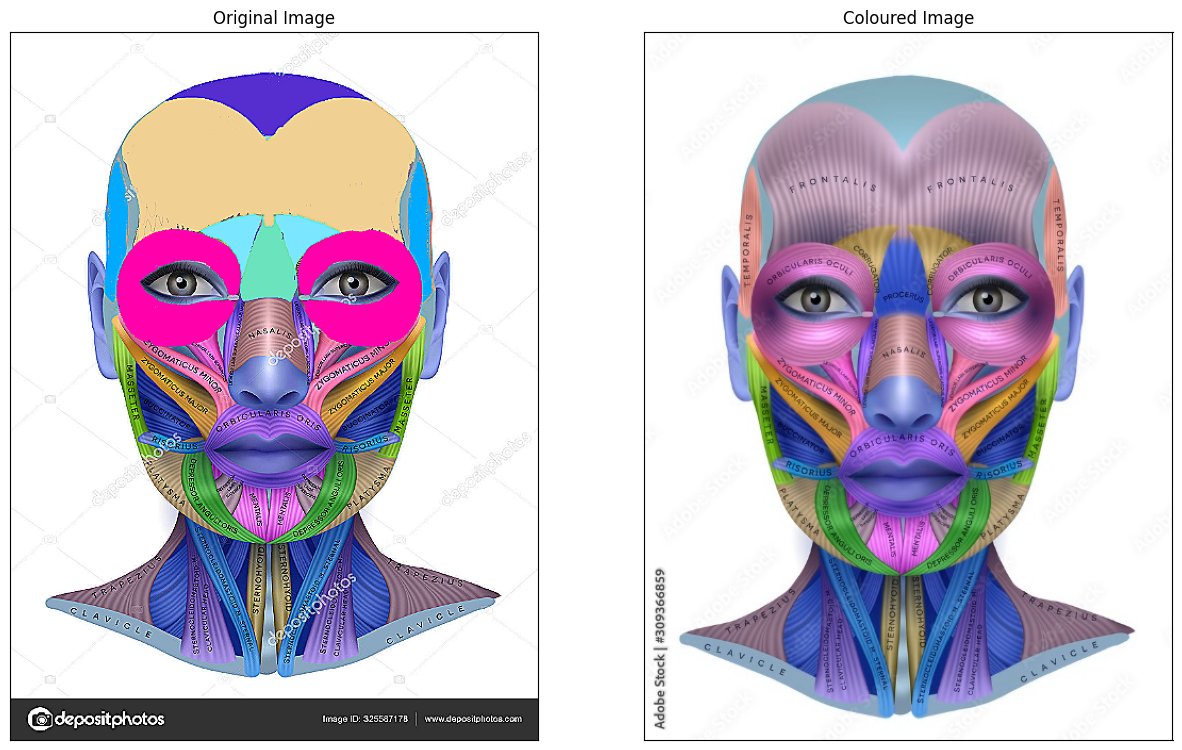

(666, 497, 3)

In [5]:
image = cv2.imread('/content/drive/MyDrive/pythonProject/facemarked.png')
mediapipe_image = cv2.imread('/content/drive/MyDrive/pythonProject/face.jpg')
base_options = python.BaseOptions(model_asset_path='/content/face_landmarker_v2_with_blendshapes.task')

image, mediapipe_image = resize_images(image, mediapipe_image, 1.5)


image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2.imwrite("/content/face_mp.jpg", mediapipe_image)
mediapipe_image = mp.Image.create_from_file("/content/face_mp.jpg")

contrast = 1
brightness = 0
image = cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)

kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
image = cv2.filter2D(image, -1, kernel)

mediapipe_image_cv = cv2.cvtColor(mediapipe_image.numpy_view(), cv2.COLOR_RGB2BGR)

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(mediapipe_image_cv)
plt.title('Coloured Image'), plt.xticks([]), plt.yticks([])
plt.show()

image.shape

In [6]:
"""
Vectorize the image for k-means. Flatten each pixel's RGB values into a single vector [R,G,B].
Reshape the image from a 2D array to a 1D array of vectors.
After clustering, apply centroid values to all pixels such that resulting image will have specified number of colours.
Reshape it back to the original image.
"""

Z = image.reshape((-1,3))
Z = np.float32(Z)

# Define k-means parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 15
attempts = 10

ret, label, center = cv2.kmeans(Z, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

# Convert center to uint8 (color values) and reshape
center = np.uint8(center)
res = center[label.flatten()]

# This image has the segment colours
result_image = res.reshape((image.shape))


## Plot the Colour Regions

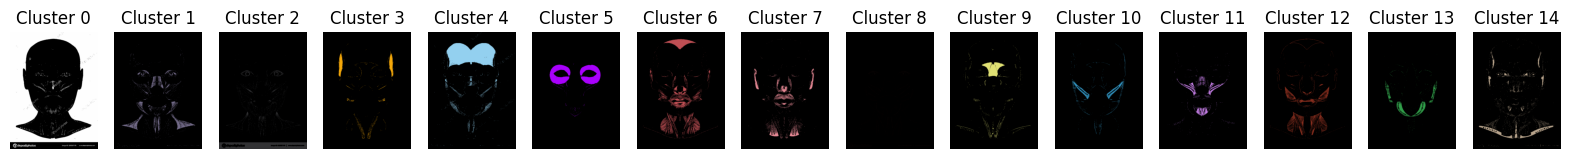

In [7]:
RESULT = result_image

fig, axes = plt.subplots(1, K, figsize=(20, 10))
for i in range(K):
    mask = (label == i).reshape(RESULT.shape[:2])  # Create a mask for cluster i
    isolated_img = np.zeros_like(RESULT)  # Create an empty image to store this cluster's section
    isolated_img[mask] = RESULT[mask]  # Apply the mask to isolate this cluster
    axes[i].imshow(cv2.cvtColor(isolated_img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Cluster {i}')
    axes[i].axis('off')
plt.show()

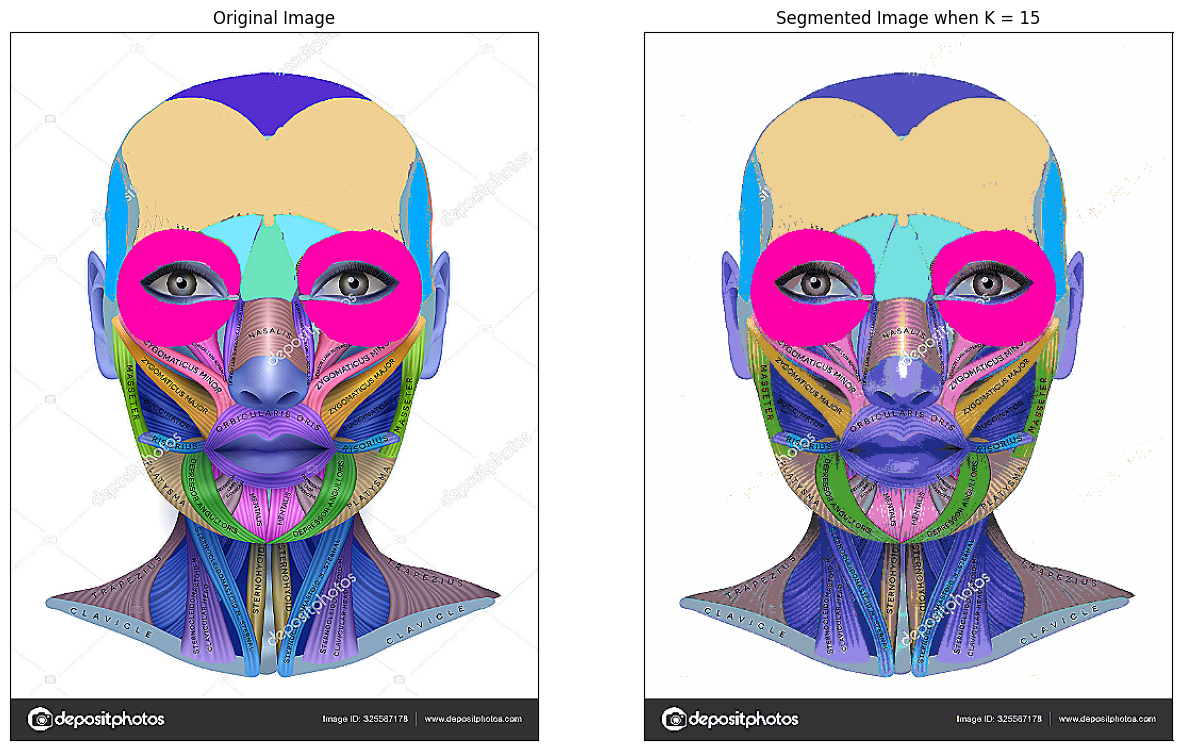

In [8]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

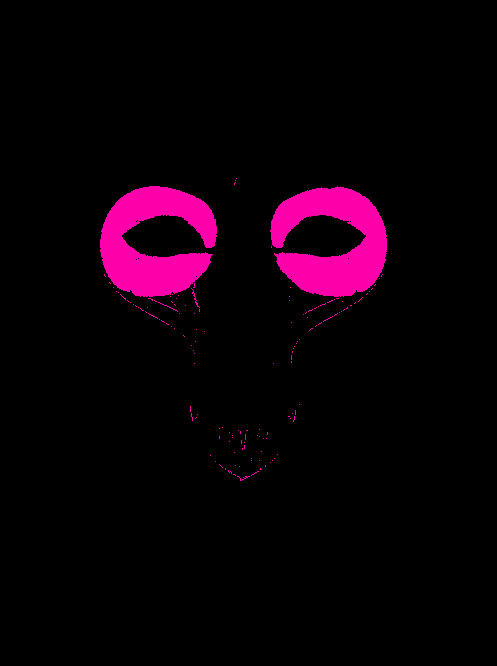

In [9]:
# Process the kmean's image result by indexing the choice of a cluster
# Extract the cluster of interest to make its own image from the kmeans result image by creating a mask

CLUSTER = 5

mask = (label == CLUSTER).reshape(result_image.shape[:2])  # Create a mask for cluster i
isolated_img = np.zeros_like(result_image)  # Create an empty image to store this cluster's section
isolated_img[mask] = result_image[mask]  # Apply the mask to isolate this cluster
cv2_imshow(cv2.cvtColor(isolated_img, cv2.COLOR_BGR2RGB))

# isolated_img -> is what we need

In [10]:
print("isolated image shape = ", isolated_img.shape)
isolated_2d_image = isolated_img.reshape(isolated_img.shape[0],isolated_img.shape[1]*isolated_img.shape[2])

print("isolated image reshaped = ", isolated_2d_image.shape)
print("grey image shape = ", image_grey.shape)

isolated image shape =  (666, 497, 3)
isolated image reshaped =  (666, 1491)
grey image shape =  (666, 497)


------------
# Create a Mask with one of the Segmented Clusters
After obtaining segmented colours, create a mask to indicate where the facial landmarks should be plotting points.

In [11]:
# To project the segmented regions onto the stream, make 2 masks
# mask_grid: translated the reshaped isolated image to a mask that matched the original image shape
# mask_image: translate the reshaped isolated image to a mask to match the frame's image shape

# Pass the isolated sifted points corresponding to the region of interest

def create_masks(frame, isolated_2d_image):
  # Obtain the coordinates for the points of interest in the isolated 2D image extraction,
  # where points of interest are values greater than 0, indicating a coloured pixel.
  isolated_2d_image = cv2.resize(isolated_2d_image, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_AREA)
  isolated_sifted_points = np.where(isolated_2d_image > 0)
  height, width, _ = frame.shape
  mask_frame = np.zeros_like(frame)   # one mask to paint segmented area on frame
  mask_grid_frame = np.zeros_like(frame)

  for i in range(0,len(isolated_sifted_points[0])):
      sy = int(isolated_sifted_points[0][i])
      sx = int(isolated_sifted_points[1][i])  # correct ratio due to reshaping

      # ensure that the points from the isolation image fall within the boundary for the camera frame.
      if sx < width and sy < height:
        cv2.circle(mask_frame, (sx,sy), 2,(255), -1)
        mask_grid_frame[sy,sx] = 1

  return mask_grid_frame, mask_frame

In [12]:
def check_valid(valid_x, valid_y, mask_grid):
      valid = (valid_x < mask_grid.shape[0]) & (valid_y < mask_grid.shape[1])
      valid_x = valid_x[valid]
      valid_y = valid_y[valid]
      return np.any(mask_grid[valid_x, valid_y] == 1)


def find_landmarks_in_region(frame, detection_result, isolated_image):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(frame)
    # Create our masks here
    mask_grid, mask_frame = create_masks(frame, isolated_image)
    cv2.addWeighted(annotated_image, ALPHA, mask_frame, 1 - ALPHA, 0, annotated_image)  # Project mask on frame

    # to record the points falling in the region of interest
    mapping = []

    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks ])

        for point, landmark in enumerate(face_landmarks):
            break_out = False
            height, width, _ = annotated_image.shape
            point_x = int(landmark.x * width)
            point_y = int(landmark.y * height)

            # Creating the "acceptable" range of x and ys
            range_x = range(point_x - THRESH_X, point_x + THRESH_X+1)
            range_y = range(point_y - THRESH_Y, point_y + THRESH_Y+1)
            px, py = np.meshgrid(range_y, range_x, indexing='ij')
            valid = (py < width) & (px < height) & (point_x < width) & (point_y < height)
            valid_px = px[valid]
            valid_py = py[valid]

            if check_valid(valid_px, valid_py,mask_grid):
                  mapping.append(point)

    return mapping

In [13]:
def modify_text(image):
  if image.shape < (800,800):

    FONT_FILL_SIZE = .4
    FONT_FILL_THICKNESS = 1
    FONT_BORDER_SIZE = .4
    FONT_BORDER_THICKNESS = 2
    FONT_THICKNESS = 1
    # Landmarker Mods
    LANDMARKER_COLOUR = (0, 0, 255)
    LANDMARKER_RADIUS = 3
  else:
    FONT_FILL_SIZE = .5
    FONT_FILL_THICKNESS = 1
    FONT_BORDER_SIZE = .5
    FONT_BORDER_THICKNESS = 2
    FONT_THICKNESS = 1
    # Landmarker Mods
    LANDMARKER_COLOUR = (0, 0, 255)
    LANDMARKER_RADIUS = 7

  return FONT_FILL_SIZE, FONT_FILL_THICKNESS, FONT_BORDER_SIZE, FONT_BORDER_THICKNESS, FONT_THICKNESS, LANDMARKER_COLOUR, LANDMARKER_RADIUS


# Text Mods
BORDER_COLOUR = (255, 255, 255)
FILL_COLOUR = (0, 0, 0)

# Masking Mods
ALPHA = 0.5
THRESH_X = 2
THRESH_Y = 2

# Drawing specs for Landmarker
draw_spec_point = solutions.drawing_utils.DrawingSpec()
draw_spec_point.color = (255,255,255)
draw_spec_point.thickness = 1
draw_spec_point.circle_radius = 1

draw_spec_tesselation = solutions.drawing_utils.DrawingSpec()
draw_spec_tesselation.color = (180, 180, 180)
draw_spec_tesselation.thickness = 1




def draw_landmarks_in_region(frame, detection_result, isolated_image, region=None, injection_points=None):

    FONT_FILL_SIZE, FONT_FILL_THICKNESS, FONT_BORDER_SIZE, FONT_BORDER_THICKNESS, FONT_THICKNESS, LANDMARKER_COLOUR, LANDMARKER_RADIUS = modify_text(frame)

    def draw_fancy_text(annotated_image, point_x, point_y, LABEL, BORDER_COLOUR=(255, 255, 255), FILL_COLOUR=(0, 0, 0)):
        cv2.putText(annotated_image, LABEL, (point_x, point_y), cv2.FONT_HERSHEY_COMPLEX, FONT_BORDER_SIZE,
                    BORDER_COLOUR, FONT_BORDER_THICKNESS, cv2.LINE_AA)
        cv2.putText(annotated_image, LABEL, (point_x, point_y), cv2.FONT_HERSHEY_COMPLEX, FONT_FILL_SIZE,
                    FILL_COLOUR, FONT_FILL_THICKNESS, cv2.LINE_AA)

    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(frame)
    # Create our masks here
    mask_grid, mask_frame = create_masks(frame, isolated_image)
    cv2.addWeighted(annotated_image, ALPHA, mask_frame, 1 - ALPHA, 0, annotated_image)  # Project mask on frame


    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=draw_spec_tesselation)

        for point, landmark in enumerate(face_landmarks):
            break_out = False
            height, width, _ = annotated_image.shape
            point_x = int(landmark.x * width)
            point_y = int(landmark.y * height)

            if point in region:
              if point in injection_points:
                cv2.circle(annotated_image, (point_x,point_y), int(LANDMARKER_RADIUS*1.4), (0,0,0), -1)
                cv2.circle(annotated_image, (point_x,point_y), int(LANDMARKER_RADIUS*1.4), (255,0,0), -1)
                cv2.putText(annotated_image, "INJECTION POINT", (point_x, point_y), cv2.FONT_HERSHEY_COMPLEX, FONT_BORDER_SIZE*1, (0,0,0), FONT_BORDER_THICKNESS, cv2.LINE_AA)
                cv2.putText(annotated_image, "INJECTION POINT", (point_x, point_y), cv2.FONT_HERSHEY_COMPLEX, FONT_FILL_SIZE*1, (0,255,0), FONT_FILL_THICKNESS, cv2.LINE_AA)
              else:
                cv2.circle(annotated_image, (point_x,point_y), LANDMARKER_RADIUS, LANDMARKER_COLOUR, -1)
                draw_fancy_text(annotated_image,point_x,point_y,str(point))
            # break_out = True

    return annotated_image




/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


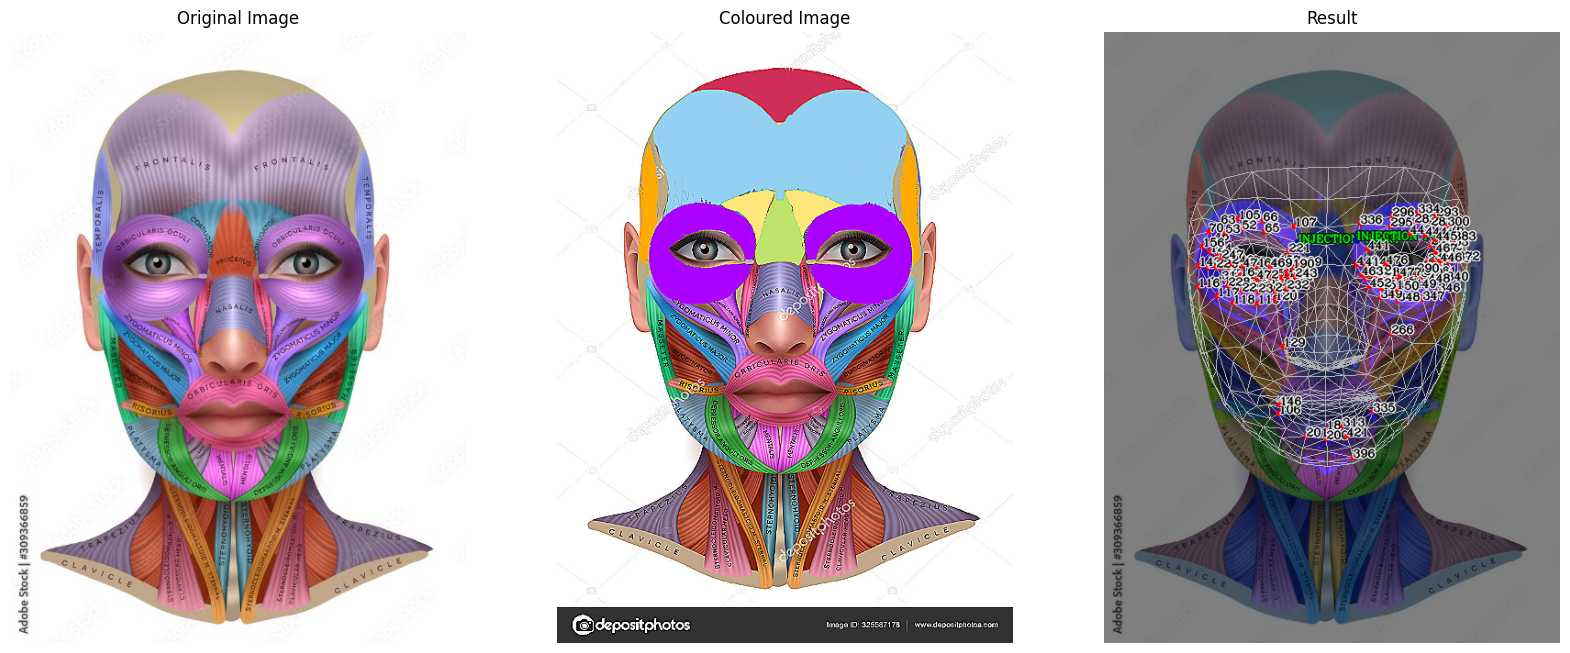

In [14]:
base_options = python.BaseOptions(model_asset_path='/content/face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)
detection_result = detector.detect(mediapipe_image)

mapping = find_landmarks_in_region(mediapipe_image.numpy_view(), detection_result, isolated_img)
annotated_image = draw_landmarks_in_region(mediapipe_image.numpy_view(), detection_result, isolated_img, mapping, [285, 55])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mediapipe_image.numpy_view())
axes[0].set_title(f'Original Image')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Coloured Image')
axes[1].axis('off')
axes[2].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Result')
axes[2].axis('off')
plt.show()



In [15]:
"""
camera = cv2.VideoCapture(1)
while camera.isOpened():
    ret, frame = camera.read()
    if not ret:
      camera.release()
    frame = cv2.flip(frame, 1)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    detection_result = detector.detector.detect(mp_image)
    annotated_image = detector.draw_landmarks_on_image(mp_image.numpy_view(), detection_result, regions=regions)
    cv2_imshow(annotated_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
"""